In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Lighten

Mounted at /content/drive
/content/drive/MyDrive/Lighten


In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.1/484.1 kB 32.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement cupy-cuda102==7.8.0 (from versions: 12.3.0)
ERROR: No matching distribution found for cupy-cuda102==7.8.0


In [3]:
!pip install einops pyyaml kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 118.1 MB/s eta 0:00:00


In [5]:
import os
import glob

# Configuration
data_root = "/content/drive/MyDrive/Lighten/LOL-v1"
train_folder = 'our485'  # Training data folder
val_folder = 'eval15'    # Validation data folder

print(f"\nFiles in {val_folder}/low:")
print(sorted(os.listdir(os.path.join(data_root, val_folder, 'low'))))
print(f"\nFiles in {val_folder}/high:")
print(sorted(os.listdir(os.path.join(data_root, val_folder, 'high'))))

def generate_file_list(folder_name, output_filename):
    # distinct paths for low and high images
    low_path = os.path.join(data_root, folder_name, 'low')
    high_path = os.path.join(data_root, folder_name, 'high')

    # Check if paths exist
    if not os.path.exists(low_path) or not os.path.exists(high_path):
        print(f"Error: Could not find directories in {folder_name}")
        return

    # Get all low light images
    low_images = sorted(glob.glob(os.path.join(low_path, '*.png')))
    lines = []

    print(f"Processing {folder_name}...")

    for low_img_path in low_images:
        # Get filename (e.g., '1.png')
        filename = os.path.basename(low_img_path)

        # Construct path to corresponding high light image
        high_img_path = os.path.join(high_path, filename)

        # Verify the pair exists
        if os.path.exists(high_img_path):
            # Write relative paths exactly as dataset.py expects them
            lines.append(f"{low_img_path} {high_img_path}")
        else:
            print(f"Warning: No high-light pair found for {filename}")

    # Write to .txt file in the data root
    output_path = os.path.join(data_root, output_filename)
    with open(output_path, 'w') as f:
        f.write('\n'.join(lines))

    print(f"Success: Generated {output_path} with {len(lines)} image pairs.")

# Generate the lists
generate_file_list(train_folder, 'LOLv1_train.txt')
generate_file_list(val_folder, 'LOLv1_val.txt')


Files in eval15/low:
['1.png', '111.png', '146.png', '179.png', '22.png', '23.png', '493.png', '547.png', '55.png', '665.png', '669.png', '748.png', '778.png', '780.png', '79.png']

Files in eval15/high:
['111.png', '79.png']
Processing our485...
Success: Generated /content/drive/MyDrive/Lighten/LOL-v1/LOLv1_train.txt with 498 image pairs.
Processing eval15...
Success: Generated /content/drive/MyDrive/Lighten/LOL-v1/LOLv1_val.txt with 2 image pairs.


In [ ]:
!python train.py --config unsupervised.yml

Using device: cuda
=> using dataset 'unpaired'
=> creating denoising-diffusion model...
Traceback (most recent call last):
  File "/content/drive/MyDrive/Lighten Diffusion/train.py", line 73, in <module>
    main()
  File "/content/drive/MyDrive/Lighten Diffusion/train.py", line 68, in main
    diffusion = DenoisingDiffusion(args, config)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Lighten Diffusion/models/ddm.py", line 192, in __init__
    self.model = Net(args, config)
                 ^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Lighten Diffusion/models/ddm.py", line 89, in __init__
    self.decom = self.load_stage1(CTDN(), 'ckpt/stage1')
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Lighten Diffusion/models/ddm.py", line 111, in load_stage1
    checkpoint = utils.logging.load_checkpoint(os.path.join(model_dir, 'stage1_weight.pth.tar'), 'cuda')
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [6]:
!python evaluate.py --config unsupervised.yml

Using device: cuda
Note: Currently supports evaluations (restoration) when run only on a single GPU!
=> using dataset 'LOLv1'
=> creating denoising-diffusion model
=> loaded checkpoint ckpt/stage2/stage2_weight.pth.tar step 0
processing image 111.png, time=2.0770576000213623
processing image 79.png, time=0.3803110122680664


=> loaded checkpoint ckpt/stage2/stage2_weight.pth.tar step 0
Model loaded.
Using image: /content/drive/MyDrive/Lighten/LOL-v1/eval15/low/179.png


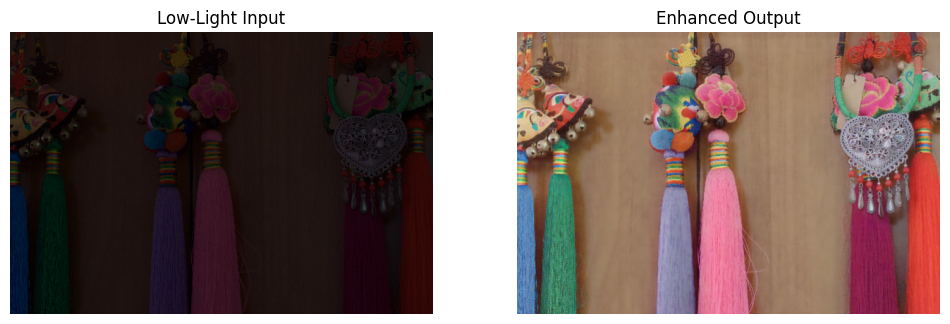

In [7]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace


# ============================
# SINGLE IMAGE INFERENCE (COLAB)
# ============================

import os
import random
import torch
import torch.nn.functional as F
import yaml
import argparse
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# ---- IMPORT YOUR MODEL CLASSES ----
from models import DenoisingDiffusion, DiffusiveRestoration


# -----------------------------------
# 1. LOAD CONFIG + CHECKPOINT
# -----------------------------------
with open("configs/unsupervised.yml", "r") as f:
    cfg = yaml.safe_load(f)

config = dict2namespace(cfg)
config.device = torch.device("cuda")

args = argparse.Namespace(
    resume="ckpt/stage2/stage2_weight.pth.tar",  # YOUR CHECKPOINT
    image_folder="results/",
    mode="evaluation"
)

# load trained model exactly like evaluate.py
diffusion = DenoisingDiffusion(args, config)
model = DiffusiveRestoration(diffusion, args, config)
diffusion.model.eval()

print("Model loaded.")


# -----------------------------------
# 2. SELECT RANDOM IMAGE FROM DATASET
# -----------------------------------
data_root = "/content/drive/MyDrive/Lighten/LOL-v1/eval15/low"

img_name = random.choice(os.listdir(data_root))
img_path = os.path.join(data_root, img_name)

print("Using image:", img_path)

img = Image.open(img_path).convert("RGB")
to_tensor = T.ToTensor()
x = to_tensor(img).unsqueeze(0).to(config.device)


# -----------------------------------
# 3. PREPROCESS (PADDING REQUIRED BY UNET)
# -----------------------------------
b, c, h, w = x.shape
H = (h + 63) // 64 * 64
W = (w + 63) // 64 * 64
x_pad = F.pad(x, (0, W - w, 0, H - h), mode="reflect")


# -----------------------------------
# 4. RUN MODEL INFERENCE
# -----------------------------------
with torch.no_grad():
    out = diffusion.model(torch.cat([x_pad, x_pad], dim=1))["pred_x"]
    out = out[:, :, :h, :w]  # remove padding
    out_img = out.squeeze().cpu().clamp(0, 1)


# -----------------------------------
# 5. PLOT BEFORE & AFTER
# -----------------------------------
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Low-Light Input")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Enhanced Output")
plt.imshow(out_img.permute(1, 2, 0))
plt.axis("off")

plt.show()


Saving ll.jpg to ll (4).jpg


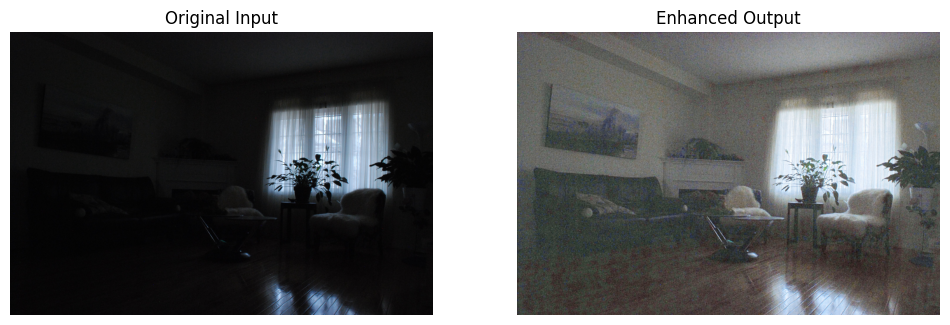

In [9]:
###Random image from internet

from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torch.nn.functional as F

# upload any image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# load image
img = Image.open(img_path).convert("RGB")

# preprocess
to_tensor = T.ToTensor()
x = to_tensor(img).unsqueeze(0).cuda()

# pad
b, c, h, w = x.shape
H = (h + 63) // 64 * 64
W = (w + 63) // 64 * 64
x_pad = F.pad(x, (0, W - w, 0, H - h), mode="reflect")

# infer
with torch.no_grad():
    out = diffusion.model(torch.cat([x_pad, x_pad], dim=1))["pred_x"]
    out = out[:, :, :h, :w]
    out_img = out.squeeze().cpu().clamp(0,1)

# show
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original Input")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Enhanced Output")
plt.imshow(out_img.permute(1,2,0))
plt.axis("off")
plt.show()


In [ ]:
import cv2
import os

def split_video_into_chunks(video_path, chunk_size=30, output_dir="frames"):
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"FPS: {fps}, Total frames: {total_frames}")

    chunk_idx = 0
    frame_idx = 0

    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frames.append(frame)
        frame_idx += 1

        # once we accumulate 30 frames → save chunk
        if len(frames) == chunk_size:
            chunk_folder = os.path.join(output_dir, f"chunk_{chunk_idx}")
            os.makedirs(chunk_folder, exist_ok=True)

            for i, f in enumerate(frames):
                cv2.imwrite(os.path.join(chunk_folder, f"{i:03d}.png"), f)

            frames = []
            chunk_idx += 1

    # save remaining frames (if any)
    if len(frames) > 0:
        chunk_folder = os.path.join(output_dir, f"chunk_{chunk_idx}")
        os.makedirs(chunk_folder, exist_ok=True)

        for i, f in enumerate(frames):
            cv2.imwrite(os.path.join(chunk_folder, f"{i:03d}.png"), f)

    cap.release()
    print("Finished splitting into chunks.")


In [ ]:
split_video_into_chunks("lowwalk.mp4", chunk_size=30)


FPS: 24.0, Total frames: 192
Finished splitting into chunks.


In [ ]:
import torch
import torchvision.transforms as T
import torch.nn.functional as F
from PIL import Image

to_tensor = T.ToTensor()

def enhance_frame(frame_bgr):
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)

    x = to_tensor(pil_img).unsqueeze(0).cuda()

    b, c, h, w = x.shape
    H = (h + 63) // 64 * 64
    W = (w + 63) // 64 * 64
    x_pad = F.pad(x, (0, W - w, 0, H - h), mode="reflect")

    with torch.no_grad():
        out = diffusion.model(torch.cat([x_pad, x_pad], dim=1))["pred_x"]
        out = out[:, :, :h, :w]
        out_img = out.squeeze().cpu().clamp(0, 1)

    out_np = (out_img.permute(1,2,0).numpy() * 255).astype("uint8")
    out_bgr = cv2.cvtColor(out_np, cv2.COLOR_RGB2BGR)
    return out_bgr


In [ ]:
import glob

def enhance_all_chunks(input_dir="frames", output_dir="enhanced_frames"):
    os.makedirs(output_dir, exist_ok=True)

    chunk_folders = sorted(glob.glob(os.path.join(input_dir, "chunk_*")))

    for chunk in chunk_folders:
        chunk_name = os.path.basename(chunk)
        out_chunk = os.path.join(output_dir, chunk_name)
        os.makedirs(out_chunk, exist_ok=True)

        frame_paths = sorted(glob.glob(os.path.join(chunk, "*.png")))

        print(f"Enhancing {chunk_name} ({len(frame_paths)} frames)")

        for fp in frame_paths:
            frame = cv2.imread(fp)
            enhanced = enhance_frame(frame)

            fname = os.path.basename(fp)
            cv2.imwrite(os.path.join(out_chunk, fname), enhanced)

enhance_all_chunks("frames", "enhanced_frames")


Enhancing chunk_0 (30 frames)
Enhancing chunk_1 (30 frames)
Enhancing chunk_2 (30 frames)
Enhancing chunk_3 (30 frames)
Enhancing chunk_4 (30 frames)
Enhancing chunk_5 (30 frames)
Enhancing chunk_6 (12 frames)


In [ ]:
def combine_frames_to_video(input_dir="enhanced_frames", output_path="enhanced_video.mp4", fps=30):
    chunk_folders = sorted(glob.glob(os.path.join(input_dir, "chunk_*")))

    # read first frame to get resolution
    first_chunk = chunk_folders[0]
    first_frame = cv2.imread(sorted(glob.glob(os.path.join(first_chunk, "*.png")))[0])
    h, w = first_frame.shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    for chunk in chunk_folders:
        frame_paths = sorted(glob.glob(os.path.join(chunk, "*.png")))
        for fp in frame_paths:
            frame = cv2.imread(fp)
            out.write(frame)

    out.release()
    print("Enhanced video saved to:", output_path)

combine_frames_to_video("enhanced_frames", "enhanced_lowwalk.mp4", fps=30)


Enhanced video saved to: enhanced_lowwalk.mp4


=> loaded checkpoint model_last.pth step 0
Model loaded.
Using image: /content/drive/MyDrive/Lighten/LOL-v1/eval15/low/146.png


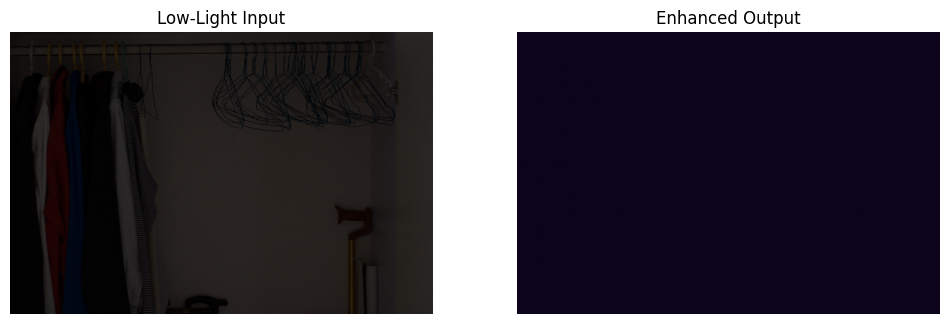

In [ ]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace


# ============================
# SINGLE IMAGE INFERENCE (COLAB)
# ============================

import os
import random
import torch
import torch.nn.functional as F
import yaml
import argparse
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# ---- IMPORT YOUR MODEL CLASSES ----
from models import DenoisingDiffusion, DiffusiveRestoration


# -----------------------------------
# 1. LOAD CONFIG + CHECKPOINT
# -----------------------------------
with open("configs/unsupervised.yml", "r") as f:
    cfg = yaml.safe_load(f)

config = dict2namespace(cfg)
config.device = torch.device("cuda")

args = argparse.Namespace(
    resume="model_last.pth",  # YOUR CHECKPOINT
    image_folder="results/",
    mode="evaluation"
)

# load trained model exactly like evaluate.py
diffusion = DenoisingDiffusion(args, config)
model = DiffusiveRestoration(diffusion, args, config)
diffusion.model.eval()

print("Model loaded.")


# -----------------------------------
# 2. SELECT RANDOM IMAGE FROM DATASET
# -----------------------------------
data_root = "/content/drive/MyDrive/Lighten/LOL-v1/eval15/low"

img_name = random.choice(os.listdir(data_root))
img_path = os.path.join(data_root, img_name)

print("Using image:", img_path)

img = Image.open(img_path).convert("RGB")
to_tensor = T.ToTensor()
x = to_tensor(img).unsqueeze(0).to(config.device)


# -----------------------------------
# 3. PREPROCESS (PADDING REQUIRED BY UNET)
# -----------------------------------
b, c, h, w = x.shape
H = (h + 63) // 64 * 64
W = (w + 63) // 64 * 64
x_pad = F.pad(x, (0, W - w, 0, H - h), mode="reflect")


# -----------------------------------
# 4. RUN MODEL INFERENCE
# -----------------------------------
with torch.no_grad():
    out = diffusion.model(torch.cat([x_pad, x_pad], dim=1))["pred_x"]
    out = out[:, :, :h, :w]  # remove padding
    out_img = out.squeeze().cpu().clamp(0, 1)


# -----------------------------------
# 5. PLOT BEFORE & AFTER
# -----------------------------------
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Low-Light Input")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Enhanced Output")
plt.imshow(out_img.permute(1, 2, 0))
plt.axis("off")


plt.show()


In [ ]:
ckpt = torch.load("model_last.pth")
print(ckpt.keys())

dict_keys(['epoch', 'model_state', 'optimizer_state', 'history'])
